# Airbnb Price Predictions

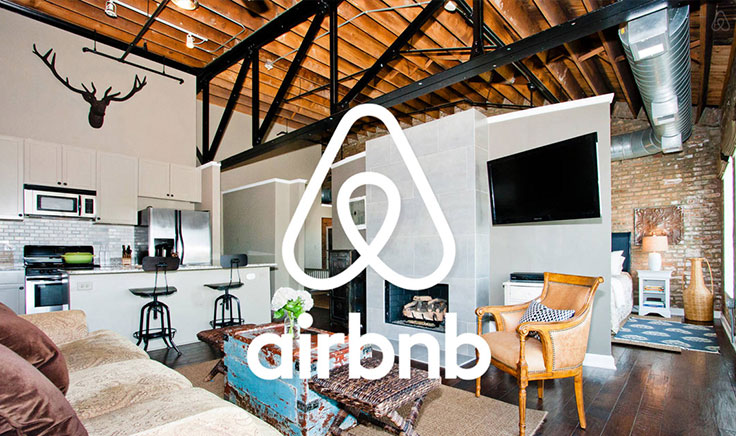

In this project we take data of Airbnb listings in the US and try to predict the price of stay in that listing. <br>
The source of the dataset: <br>
https://www.kaggle.com/stevezhenghp/airbnb-price-prediction#train.csv
<br>
<br>
The data includes 74411 listings and 29 columns - including log_price, what we are trying to predict. <br>
Some columns will not be used as features, such as ID and thumbnail URL, so we are left with 26 columns to process and consider as features. <br>
There was no information about this data so we assume that since all the listings are in the us, the price (or log_price) that we are trying to predict is the general pricing per 1 night stay of the listing, in USD, not for specific dates/seasons and not including additional fees, i.e. cleaning and airbnb service fees.<br>
<br>
The data is for 6 cities across the US: NYC, LA, San Francisco, Washington DC, Boston and Chicago 

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import PolynomialFeatures,MaxAbsScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder, KBinsDiscretizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer 

from sklearn.model_selection import cross_val_score, train_test_split as split

from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomTreesEmbedding

from sklearn.metrics import roc_curve, mean_absolute_error, make_scorer

import warnings
warnings.filterwarnings('ignore')

Helpful functions:

In [ ]:
#Data preprocessin functions:

def str_to_bool(s):
    if s=='t':
        return True
    else: 
        return False
    

def str_to_rate(s):
    if pd.isnull(s)==False:
        return float(s.replace('%',''))
    else: 
        return s

def extract_list_val(s):
    for c in ['{','}','"']:
        s=s.replace(c,'')
    for c in ['/',':',' ','-','.','&',')','(','\'']:
        s=s.replace(c,'_')
    s=s.replace('matress','mattress')
    return s.split(',')

def preprocessing_w_lat_long(data):
    data=data[data['log_price']!=0]
    data.drop(columns=['id','last_review', 'name', 'neighbourhood','host_has_profile_pic',
                             'host_since', 'description', 'first_review','thumbnail_url','zipcode'],inplace =True)
    data['property_type']=data['property_type'].replace(dict2)
    # data['property_type']=data['property_type'].apply(extract_list_val).str.join(' ')#.str.replace(' ','_')
    data['room_type']=data['room_type'].str.replace(' ','_')
    data['bed_type']=data['bed_type'].str.replace(' ','_')
    data['host_response_rate'] =data['host_response_rate'].apply(str_to_rate)
    data['host_identity_verified']=data['host_identity_verified'].apply(str_to_bool)
    data['instant_bookable']=data['instant_bookable'].apply(str_to_bool).astype(float)
    data['cleaning_fee']=data['cleaning_fee'].apply(str_to_bool).astype(float)
    data['amenities']=data['amenities'].apply(extract_list_val).str.join(' ')
    return data

def preprocessing_no_lat_long(data):
    data=data[data['log_price']!=0]
    data=data[data['neighbourhood'].isna()==False]
    data.drop(columns=['id','last_review', 'name', 'city','host_has_profile_pic',
                           'host_since', 'description', 'first_review','thumbnail_url',
                           'zipcode','longitude','latitude'],inplace =True)
    data['property_type']=data['property_type'].replace(dict2)
    data['room_type']=data['room_type'].str.replace(' ','_')
    data['bed_type']=data['bed_type'].str.replace(' ','_')
    data['host_response_rate'] =data['host_response_rate'].apply(str_to_rate)
    data['host_identity_verified']=data['host_identity_verified'].apply(str_to_bool)
    data['instant_bookable']=data['instant_bookable'].apply(str_to_bool).astype(float)
    data['cleaning_fee']=data['cleaning_fee'].apply(str_to_bool).astype(float)
    data['amenities']=data['amenities'].apply(extract_list_val).str.join(' ')
    data['neighbourhood']=data['neighbourhood'].str.lower().replace('castle hill ','castle hill')
    return data


# scoring functions
def MAE(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


#functions to get columns for featrue tranformers   
def get_col_to_fillna_most_frequent(df):
    return df[col_to_fillna_most_frequent]

def get_col_to_fillna_mean(df):
    return df[col_to_fillna_mean]

def get_col_to_get_dummies(df):
    return df[col_to_getdummies]


def get_col_to_get_dummies_NYC(df):
    return df[col_to_getdummies_NYC]

def get_lat_long(df):
    return df[['latitude','longitude']]

def get_amenities(df):
    return df['amenities']

def get_amenities2(df):
    return df[['amenities']]

def get_col_no_change(df):
    return df[col_no_change]

def get_sum_amenities(s):
    return pd.DataFrame(s.apply(lambda s: len(s.split(' '))))

#functions for model fit, predict and results
def time_convert (t):
    h,m1=divmod(t, 3600)
    m,s=divmod(m1, 60) 
    return h, m ,s

def get_mean_cv_score(name, model, X_train, y_train, num_cv, n_verbose,scoring_param):
    print ('Model: '+name)
    print ('Begin CV fit')
    t0 = time.time()
    c_val=cross_val_score(model, X_train, y_train, cv=num_cv, verbose=n_verbose, scoring=scoring_param)
    t1 = time.time()
    h, m ,s=time_convert(t1-t0)
    print('CV ended. Elapsed time: {0:.0f} hours, {1:.0f} minutes and {2:.0f} seconds'.format(h,m,s))
    return -(c_val.mean().round(4))


def get_results (pipes_dict, X_train, y_train,  X_test, y_test, num_cv, 
                 n_verbose, scoring_param, df_data_and_results, df_all_results):
    for name,model in pipes_dict.items():
        mean_cv_score=get_mean_cv_score(name ,model, X_train, y_train, num_cv, n_verbose,scoring_param)
        print ('Begin '+name+' model fit')
        t1 = time.time()
        model.fit(X_train,y_train)
        t2 = time.time()
        h, m ,s=time_convert(t2-t1)
        print('Model fit ended. Elapsed time: {0:.0f} hours, {1:.0f} minutes and {2:.0f} seconds'.format(h,m,s))
        y_pred=model.predict(X_test)
        df_data_and_results[('Price_pred_'+name)]=np.exp(y_pred)
        df_data_and_results[('Price_diff_'+name)]=np.exp(y_test)-np.exp(y_pred)
        df_all_results=df_all_results.append ({ 'Model':name,
                                                'CV_train_mean_MAE_score': mean_cv_score,
                                                'Test_MAE_score':          round(MAE(y_test,y_pred), 4),
                                                'Min_diff':                 df_data_and_results[('Price_diff_'+name)].min(),
                                                'Max_diff':                 df_data_and_results[('Price_diff_'+name)].max(), 
                                                'Mean_diff':                df_data_and_results[('Price_diff_'+name)].mean(), 
                                                'Median_diff':              df_data_and_results[('Price_diff_'+name)].median(),
                                                'STD_diff':                 df_data_and_results[('Price_diff_'+name)].std(),
                                                '10th percentile':          df_data_and_results[('Price_diff_'+name)].quantile(q=[0.1,0.9], interpolation='linear')[0.1],
                                                '90th percentile':          df_data_and_results[('Price_diff_'+name)].quantile(q=[0.1,0.9], interpolation='linear')[0.9]
                                              },
                                                ignore_index = True)
        print('======================================================================================\n')
    return df_data_and_results, df_all_results

#Graph generation functions:
def get_diff_hist (pipes_dict,df_data_and_results, df_all_results):
    for name,model in pipes_dict.items():
        fig, ax = plt.subplots(figsize=(14,5))
        sns.set_context(rc={"lines.linewidth": 3.5})#
        sns.distplot(df_data_and_results[('Price_diff_'+name)],ax=ax,color='red')
        plt.title(name+' Price_diff histogram')
        ax.set_xlim(df_all_results['Min_diff'].min(),df_all_results['Max_diff'].max())

def get_prediction_cluster_graph(pipes_dict, y_test, df_data_and_results):
    for name,model in pipes_dict.items():
        plt.figure()
        plt.plot(y_test,np.log(df_data_and_results[('Price_pred_'+name)]),'.', label = 'Result Data')
        plt.plot([2,9],[2,9], label = 'Ideal')
        plt.axes().set_aspect('equal')
        plt.legend()
        plt.title(name+' (y_true,y_pred) vs. ideal')


### Exploration and Preprocessing

In [ ]:
data = pd.read_csv('../input/airbnb-price-prediction/train.csv')

In [ ]:
data.head()

In [ ]:
data.info()

The data we have consists of floats, integers, booleans and strings (some of which should be boolean, some should be floats, some should be handled as single entities). Also, for some features we have NANs that will have to be filled using tranfromers.

In [ ]:
pd.set_option('display.max_colwidth', 0)
data[['property_type','room_type','bed_type','cancellation_policy',
      'cleaning_fee','city','host_has_profile_pic','host_identity_verified',
     'host_response_rate','instant_bookable','neighbourhood']].agg(['unique']).transpose()

In [ ]:
data['property_type'].value_counts()

For property type we have 35 property types. To reduce number of features, property type is grouped in to 5 catagories: Apartment, House, Hotel1, Hotel2 and other, to use with OneHotEncoder <br>
(Note: encodging and PCA yealded worse results then "manual" grouping)

In [ ]:
dict1 = {'Apartment':['Condominium','Timeshare','Loft','Serviced apartment','Guest suite'],
         'House':['Vacation home','Villa','Townhouse','In-law','Casa particular'],
         'Hotel1':['Dorm','Hostel','Guesthouse'],
         'Hotel2':['Boutique hotel','Bed & Breakfast'],
         'Other':['Island','Castle','Yurt','Hut','Chalet','Treehouse',
                  'Earth House','Tipi','Cave','Train','Parking Space','Lighthouse',
                 'Tent','Boat','Cabin','Camper/RV','Bungalow']
        }
dict2 = {i : k for k, v in dict1.items() for i in v}
data['property_type'].replace(dict2).value_counts()

Neighbourhood feature has 619 values and some grouping of it is needed, to not create too many features

In [ ]:
data['neighbourhood'].nunique()

In [ ]:
pd.DataFrame(data.groupby(['city'])['neighbourhood'].nunique())

Since we have lat-long information of the properties, we decided to use KNN regressor (with price, not log price, as prediction). This will be one of the transformers. So for all the data, Neighborhood will be dropped. <br>
Later we show neighborhood grouping in NYC only.

We also dropped other features that we decided not to use, since we believe they won't contribute to the model:
id, last_review, name, host_has_profile_pic (99% of hosts had profile pics), host_since, description, first_review, thumbnail_url and zipcode

In [ ]:
data_clean_all=data.copy()
data_clean_all=preprocessing_w_lat_long(data_clean_all)
data_clean_all.head()

In [ ]:
data_clean_all.info()

In [ ]:
data_clean_all.shape

We create lists of features for the tranformers:

In [ ]:
#columns to fill Nan with most frequent
col_to_fillna_most_frequent=['beds','bedrooms','bathrooms','host_identity_verified']

#columns to fill Nan with mean
col_to_fillna_mean=['host_response_rate','review_scores_rating']

#columns for get_dummies (one hot encoding)
col_to_getdummies=['property_type','room_type','bed_type','cancellation_policy','city']

#columns that won't be changed
col_no_change=['accommodates','number_of_reviews']

For exploration purposes we look at the price be city box plots:

In [ ]:
city_price_df = data_clean_all.copy()[['city','log_price']]
city_price_df['Price'] = np.exp(city_price_df['log_price'])
city_price_df[['city','Price']].boxplot(by = 'city', figsize=(10, 8), vert=False)

the boxblot shows that they are many out liers twords the higher prices in all the cities, so the prices are quite skewed. predicting log_price can help with this skewness.

## Regression models

We decided to use 2 regression models: Linear Regression (LR) and Random Forest regressor (RF), for predicting log_price. <br>
In addition, KNN regressor was used to create a price grouping feature based on lat-long info.<br>
<br>
LR and RF ran with 2 types of transformers, with and without polynomioal features

In [ ]:
#scoring functions
MAE_scorer = make_scorer(MAE, greater_is_better=False)
MAPE_scorer = make_scorer(MAPE, greater_is_better=False)

In [ ]:
KNN_neighbors=200
RF_n_estimators=50
RF_min_samples_split=50
TSVD_n_components=10
num_cv=5
n_verbose = 3
scoring_param=MAE_scorer

PCA_features=PCA()
TruncatedSVD_features=TruncatedSVD(n_components=TSVD_n_components)
lin_regressor= LinearRegression()
RF_regressor = RandomForestRegressor(n_estimators=RF_n_estimators, min_samples_split=RF_min_samples_split)
KNN_Reg = KNNR(n_neighbors=KNN_neighbors)

A class created for the KNN regressor for lat-long-price:

In [ ]:
class MyTransformer(TransformerMixin, BaseEstimator):
    '''A template for a custom transformer.'''

    def __init__(self, model):
        self.model=model
        pass

    def fit(self, X, y=None):
        self.model.fit(X, np.exp(y))
        return self

    def transform(self, X):
        # transform X via code or additional methods
        return pd.DataFrame(self.model.predict(X))

Tranformers:

In [ ]:
Transformer_fillna_most_frequent = Pipeline([('Select_col_to_fillna_most_frequent', FunctionTransformer(func=get_col_to_fillna_most_frequent, validate=False)),
                                            ('Fill_Null',                           SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                                            ('To_float_transformer',                FunctionTransformer(func=lambda x: x.astype(float) ,validate=False))
                                            ])

In [ ]:
Transformer_fillna_mean = Pipeline([('Select_col_to_fillna_mean',    FunctionTransformer(func=get_col_to_fillna_mean, validate=False)),
                                    ('Fill_Null',                    SimpleImputer(missing_values=np.nan, strategy='mean'))
                                  ])

In [ ]:
Transformer_OneHotEncoder= Pipeline([('Select_col_to_get_dummies',      FunctionTransformer(func=get_col_to_get_dummies, validate=False)),
                                     ('OneHotEncoder_transform',        OneHotEncoder(handle_unknown='ignore'))
                                  ])

In [ ]:
Transformer_amenities = Pipeline([('Select_col_to_get_amenities',  FunctionTransformer(func=get_amenities, validate=False)),
                                  ('CountVectorizer_transform',    CountVectorizer(min_df=0.02)),
                                  ('Feature_extractor_TSVD',     TruncatedSVD_features)
                                 ])

In [ ]:

Transformer_sum_amenities=Pipeline([('Select_col_to_get_amenities',  FunctionTransformer(func=get_amenities, validate=False)),
                                    ('Get_sum_amenities',            FunctionTransformer(func=get_sum_amenities, validate=False)),
                                   ])

In [ ]:
Transformer_get_columns = Pipeline ([('Select_col_no_change', FunctionTransformer(func=get_col_no_change, validate=False))])


In [ ]:
Transformer_lat_long = Pipeline ([('Select_col_lat_long_price', FunctionTransformer(func=get_lat_long, validate=False)),                                
                                  ('MyTransformer', MyTransformer(KNN_Reg))    
                                ])

In [ ]:
FeatureUnionTransformer = FeatureUnion([('FTfillna_frequent',   Transformer_fillna_most_frequent),
                                        ('FTfillna_mean',       Transformer_fillna_mean),
                                        ('FTget_OneHotEncoder', Transformer_OneHotEncoder),                  
                                        ('FTamenities',         Transformer_amenities),
                                        ('FT_sum_amenities',    Transformer_sum_amenities),
                                        ('FT_lat_long',         Transformer_lat_long),
                                        ('FT_get_columns',      Transformer_get_columns)
                                       ])

In [ ]:
#Transformer with polynomial features
Full_Transformer_poly = Pipeline([('Feature_Engineering', FeatureUnionTransformer),
                                  ('Polynomial_Transformer', PolynomialFeatures(degree=2, interaction_only=True)),
                                  ('Min_Max_Transformer', MaxAbsScaler())
                                 ])

#Transformer without polynomial features
Full_Transformer = Pipeline([('Feature_Engineering', FeatureUnionTransformer),
                             ('Min_Max_Transformer', MaxAbsScaler())
                            ])


Regression model pipelines:

In [ ]:
lin_reg_pipe= Pipeline([('Feature_transformer', Full_Transformer),
                        ('Linear_regressor', lin_regressor)
                       ])

lin_reg_poly_pipe= Pipeline([('Feature_transformer_poly', Full_Transformer_poly),
                             ('Linear_regressor', lin_regressor)
                            ])

RF_pipe= Pipeline([('Feature_transformer', Full_Transformer),
                    ('RFE_regressor', RF_regressor)
                  ])

RF_poly_pipe= Pipeline([('Feature_transformer_poly', Full_Transformer_poly),
                        ('RFE_regressor', RF_regressor)
                       ])

Split the data to train and test:

In [ ]:
X_train_all, X_test_all, y_train_all, y_test_all = split(data_clean_all.drop(axis=1, columns=['log_price']), 
                                                         data_clean_all['log_price'], 
                                                         test_size =0.3, random_state=123)


Run all the regression models

In [ ]:
#all regressors
pipes_dict_all = {'LG':lin_reg_pipe, 'LG_poly':lin_reg_poly_pipe,'RF':RF_pipe, 'RF_poly':RF_poly_pipe}

#reset DF to collect results
df_all_results_all=pd.DataFrame(columns=['Model','CV_train_mean_MAE_score','Test_MAE_score',
                                          'Min_diff','Max_diff','Mean_diff','Median_diff',
                                          'STD_diff','10th percentile','90th percentile'])

df_data_and_results_all=X_test_all.copy()
df_data_and_results_all['Price_true']=np.exp(y_test_all)

In [ ]:
#Run models
df_data_and_results_all, df_all_results_all =get_results(pipes_dict_all, X_train_all, y_train_all, X_test_all, y_test_all, 
                                                         num_cv, n_verbose, scoring_param, 
                                                         df_data_and_results_all, df_all_results_all)

In [ ]:
df_all_results_all

In [ ]:
get_prediction_cluster_graph(pipes_dict_all, y_test_all, df_data_and_results_all)

In [ ]:
get_diff_hist(pipes_dict_all, df_data_and_results_all, df_all_results_all)

Using Polynomial features improves the MAE score for both LG and RF models. <br>
RF performed better than LG, and it looks like RF with polynomial features is the model we would perfer for it's MAE score on test and other measurments. However, it's looks only slightly better than RF without polynomial features and takes substantially longer to run. So, if we prefer something quick for the loss of some percision, RF without polynomial features is the choice model.

## NYC subset of the data

For NYC there's a clear seperation of neighbourhoods to boroughs. on a subset of the data for NYC, we import and externel list and merge on neighbourhood, to create a borough column, instead of neighhborhood. <br>
We will compare the results with the lat_long_price transformer

### NYC - boroughs and no lat_long

In [ ]:
NYC_data=data[data['city']=='NYC'].copy()
NYC_data=preprocessing_no_lat_long(NYC_data)
NYC_data.head()

In [ ]:
NYC = pd.read_csv('../input/nyc-neighborhoods/NYC_neighborhoods.csv', encoding = "ISO-8859-1")
NYC['neighbourhood']=NYC['neighbourhood'].str.lower().replace('castle hill ','castle hill')
NYC['borough']=NYC['borough'].str.lower()

In [ ]:
#number of neighbourhoods in each borough
NYC['borough'].value_counts()

In [ ]:
NYC_data=NYC_data.merge(NYC, on='neighbourhood',how='left').copy()
NYC_data.drop(columns=['neighbourhood'],inplace =True)

In [ ]:
#number of listings in each borough
NYC_data['borough'].value_counts()

In [ ]:
NYC_data.head()

In [ ]:
NYC_data.shape

Since city is irrelevant and borogh replaced neighborhood, we need to change the columns list of OnHotEncoder

In [ ]:
col_to_getdummies_NYC=['property_type','room_type','bed_type','cancellation_policy','borough']

Split the data:

In [ ]:
X_train_NYC, X_test_NYC, y_train_NYC, y_test_NYC = split(NYC_data.drop(axis=1, columns=['log_price']), 
                                                         NYC_data['log_price'], 
                                                         test_size =0.3, random_state=123)

Adjust tranformers and models for the new data structure:

In [ ]:
Transformer_OneHotEncoder_NYC= Pipeline([('Select_col_to_get_dummies',      FunctionTransformer(func=get_col_to_get_dummies_NYC, validate=False)),
                                         ('OneHotEncoder_transform',        OneHotEncoder(handle_unknown='ignore'))
                                        ])


In [ ]:
FeatureUnionTransformer_NYC = FeatureUnion([('FTfillna_frequent',   Transformer_fillna_most_frequent),
                                            ('FTfillna_mean',       Transformer_fillna_mean),
                                            ('FTget_OneHotEncoder', Transformer_OneHotEncoder_NYC),                  
                                            ('FTamenities',         Transformer_amenities),
                                            ('FT_sum_amenities',    Transformer_sum_amenities),
                                            ('FT_get_columns',      Transformer_get_columns)
                                       ])


In [ ]:
Full_Transformer_poly_NYC = Pipeline([('Feature_Engineering', FeatureUnionTransformer_NYC),
                                      ('Polynomial_Transformer', PolynomialFeatures(degree=2, interaction_only=True)),
                                      ('Min_Max_Transformer', MaxAbsScaler())
                                     ])

Full_Transformer_NYC = Pipeline([('Feature_Engineering', FeatureUnionTransformer_NYC),
                                 ('Min_Max_Transformer', MaxAbsScaler())
                                ])

In [ ]:
lin_reg_pipe_NYC= Pipeline([('Feature_transformer', Full_Transformer_NYC),
                            ('Linear_regressor', lin_regressor)
                           ])

lin_reg_poly_pipe_NYC= Pipeline([('Feature_transformer_poly', Full_Transformer_poly_NYC),
                                 ('Linear_regressor', lin_regressor)
                                ])

RF_pipe_NYC= Pipeline([('Feature_transformer', Full_Transformer_NYC),
                        ('RFE_regressor', RF_regressor)
                      ])

RF_poly_pipe_NYC= Pipeline([('Feature_transformer_poly', Full_Transformer_poly_NYC),
                            ('RFE_regressor', RF_regressor)
                           ])

Run the Models:

In [ ]:
#all regressors
pipes_dict_NYC = {'LG':lin_reg_pipe_NYC, 'LG_poly':lin_reg_poly_pipe_NYC,'RF':RF_pipe_NYC, 'RF_poly':RF_poly_pipe_NYC}


#reset DF to collect results
df_all_results_NYC=pd.DataFrame(columns=['Model','CV_train_mean_MAE_score','Test_MAE_score',
                                          'Min_diff','Max_diff','Mean_diff','Median_diff',
                                          'STD_diff','10th percentile','90th percentile'])

df_data_and_results_NYC=X_test_NYC.copy()
df_data_and_results_NYC['Price_true']=np.exp(y_test_NYC)

In [ ]:
#Run models
df_data_and_results_NYC, df_all_results_NYC =get_results(pipes_dict_NYC, X_train_NYC, y_train_NYC, X_test_NYC, y_test_NYC, 
                                                         num_cv, n_verbose, scoring_param, 
                                                         df_data_and_results_NYC, df_all_results_NYC)

In [ ]:
df_all_results_NYC

In [ ]:
get_prediction_cluster_graph(pipes_dict_NYC, y_test_NYC, df_data_and_results_NYC)

In [ ]:
get_diff_hist(pipes_dict_NYC, df_data_and_results_NYC, df_all_results_NYC)

Again we see RF models have better results than LG, though adding polynomial features did not improve the test MAE score for RF. <br>
Some of the measurments are better for RF with polynomial features, and some are better for RF without. For perdiction we can't say that one is much better than the other, so the choice model is again RF without polynomial features, for it's speed.<br>
We will show next the same models performences no NYC data with the lat_long_price KNN regressor as a transformer.

### NYC - lat_long

In [ ]:
data_NYC_lat_long=data[data['city']=='NYC'].copy()
data_NYC_lat_long=preprocessing_w_lat_long(data_NYC_lat_long)

In [ ]:
data_NYC_lat_long.info()

In [ ]:
data_NYC_lat_long.shape

In [ ]:
X_train_NYC_ll, X_test_NYC_ll, y_train_NYC_ll, y_test_NYC_ll = split(data_NYC_lat_long.drop(axis=1, columns=['log_price']), 
                                                                     data_NYC_lat_long['log_price'], 
                                                                     test_size =0.3, random_state=123)

In [ ]:
pipes_dict_all_2 = {'LG':lin_reg_pipe, 'LG_poly':lin_reg_poly_pipe,'RF':RF_pipe, 'RF_poly':RF_poly_pipe}

#reset DF to collect results
df_all_results_NYC_ll=pd.DataFrame(columns=['Model','CV_train_mean_MAE_score','Test_MAE_score',
                                          'Min_diff','Max_diff','Mean_diff','Median_diff',
                                          'STD_diff','10th percentile','90th percentile'])

df_data_and_results_NYC_ll=X_test_NYC_ll.copy()
df_data_and_results_NYC_ll['Price_true']=np.exp(y_test_NYC_ll)

In [ ]:
#Run models
df_data_and_results_NYC_ll, df_all_results_NYC_ll =get_results(pipes_dict_all_2, X_train_NYC_ll, y_train_NYC_ll, X_test_NYC_ll, y_test_NYC_ll, 
                                                               num_cv, n_verbose, scoring_param, 
                                                               df_data_and_results_NYC_ll, df_all_results_NYC_ll)

In [ ]:
df_all_results_NYC_ll

In [ ]:
get_prediction_cluster_graph(pipes_dict_all_2, y_test_NYC_ll, df_data_and_results_NYC_ll)

In [ ]:
get_diff_hist(pipes_dict_all_2, df_data_and_results_NYC_ll, df_all_results_NYC_ll)

The conclusions for this data set are similar to the other tests - Polynomail features improve MAE score, RF is better than LG, but not much difference between the 2 RF models. Run time over percision may be more important to us, when we consider which model to use. <br>
<br>
The tranformer based on lat_long_price prediction with KNN regressor proved it significantly improves all the models scores when used, instead of grooping neighbourhoods by boroughs in NYC subset of the data.

### What's next?

Further work can try to explore the predictions that had the largest differences compared to the true test data, both over and under predictions (expecially over, since it seems all the models had more errors of over predictions). This can help identify what was unusual in the values of their features, and to adjust the model accordingly and improve it.<br>
In addition, some exploration of features sginifcance can be done, to see how useful our features are for the regression models. <br>
Also, there are a lot of models that we can try and use, which may perform better. For the purpose of this project we focused on 2 regressors.